In [1]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

Your runtime has 13.6 gigabytes of available RAM



In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import _LRScheduler
import torch.utils.data as data

import torchvision.transforms as transforms
import torchvision.datasets as datasets

from sklearn import decomposition
from sklearn import manifold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

import copy
import random
import time

## Data Loading and Preparation

In [3]:
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [4]:
ROOT = '.data'
train_data = datasets.CIFAR10(root = ROOT, 
                              train = True, 
                              download = True)

Files already downloaded and verified


In [5]:
means = train_data.data.mean(axis = (0,1,2)) / 255
stds = train_data.data.std(axis = (0,1,2)) / 255

In [6]:
train_transforms = transforms.Compose([
                           transforms.RandomRotation(5),
                           transforms.RandomHorizontalFlip(0.5),
                           transforms.RandomCrop(32, padding = 2),
                           transforms.ToTensor(),
                           transforms.Normalize(mean = means, 
                                                std = stds)
                       ])

test_transforms = transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize(mean = means, 
                                                std = stds)
                       ])

In [7]:
train_data = datasets.CIFAR10(ROOT, 
                              train = True, 
                              download = True, 
                              transform = train_transforms)

test_data = datasets.CIFAR10(ROOT, 
                             train = False, 
                             download = True, 
                             transform = test_transforms)

Files already downloaded and verified
Files already downloaded and verified


In [8]:
VALID_RATIO = 0.9

n_train_examples = int(len(train_data) * VALID_RATIO)
n_valid_examples = len(train_data) - n_train_examples

train_data, valid_data = data.random_split(train_data, 
                                           [n_train_examples, n_valid_examples])

In [9]:
BATCH_SIZE = 32

train_iterator = torch.utils.data.DataLoader(train_data, BATCH_SIZE, shuffle = True)

valid_iterator = torch.utils.data.DataLoader(valid_data, BATCH_SIZE, shuffle = True)

test_iterator = torch.utils.data.DataLoader(test_data, BATCH_SIZE, shuffle = True)

## Plotting Images of Dataset

In [10]:
# get some random training images
dataiter = iter(train_iterator)
images, labels = next(dataiter)

def plot_images(images, labels, classes, normalize = False):

    n_images = len(images)

    rows = int(np.sqrt(n_images))
    cols = int(np.sqrt(n_images))

    fig = plt.figure(figsize = (10, 10))

    for i in range(rows*cols):

        ax = fig.add_subplot(rows, cols, i+1)
        
        image = images[i]

        if normalize:
            image_min = image.min()
            image_max = image.max()
            image.clamp_(min = image_min, max = image_max)
            image.add_(-image_min).div_(image_max - image_min + 1e-5)

        ax.imshow(image.permute(1, 2, 0).cpu().numpy())
        ax.set_title(classes[labels[i]])
        ax.axis('off')

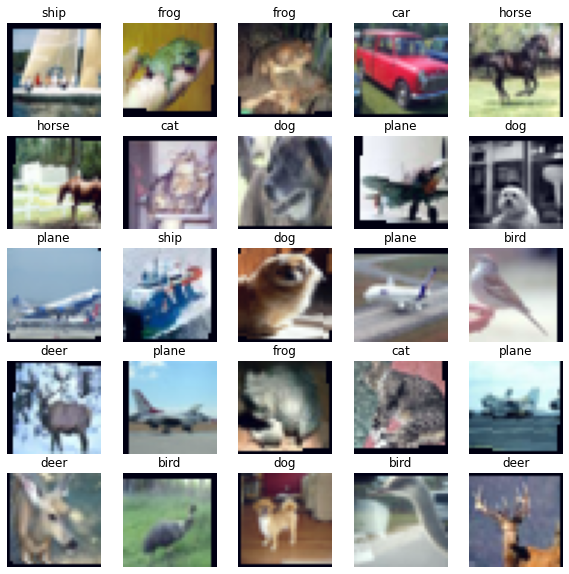

In [11]:
N_IMAGES = 25
CLASSES = ['plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
images, labels = zip(*[(image, label) for image, label in 
                           [train_data[i] for i in range(N_IMAGES)]])

classes = CLASSES

plot_images(images, labels, CLASSES, normalize = True)

## Building Basic Block And ResNet Model

In [12]:
class BasicBlock(nn.Module):
    expansion = 1
    

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()

        DROPOUT = 0.1

        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.dropout = nn.Dropout(DROPOUT)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.dropout = nn.Dropout(DROPOUT)
        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes),
                nn.Dropout(DROPOUT)
            )

    def forward(self, x):
        out = F.relu(self.dropout(self.bn1(self.conv1(x))))
        out = self.dropout(self.bn2(self.conv2(out)))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3,
                               stride=2, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 244, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 256, num_blocks[3], stride=2)
        self.linear = nn.Linear(256*block.expansion, num_classes)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
            out = F.relu(self.bn1(self.conv1(x)))
            out = self.layer1(out)
            out = self.layer2(out)
            out = self.layer3(out)
            out = self.layer4(out)
            out = self.avgpool(out)
            out = out.view(out.size(0), -1)
            out = self.linear(out)
            return F.log_softmax(out, dim=-1)


In [13]:
from torchsummary import summary

resnet18 = ResNet(BasicBlock, [2, 2, 2, 2])
resnet18.to(torch.device("cuda:0" if torch.cuda.is_available() else "cpu"))
summary(resnet18, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 16, 16]           1,728
       BatchNorm2d-2           [-1, 64, 16, 16]             128
            Conv2d-3           [-1, 64, 16, 16]          36,864
       BatchNorm2d-4           [-1, 64, 16, 16]             128
           Dropout-5           [-1, 64, 16, 16]               0
            Conv2d-6           [-1, 64, 16, 16]          36,864
       BatchNorm2d-7           [-1, 64, 16, 16]             128
           Dropout-8           [-1, 64, 16, 16]               0
        BasicBlock-9           [-1, 64, 16, 16]               0
           Conv2d-10           [-1, 64, 16, 16]          36,864
      BatchNorm2d-11           [-1, 64, 16, 16]             128
          Dropout-12           [-1, 64, 16, 16]               0
           Conv2d-13           [-1, 64, 16, 16]          36,864
      BatchNorm2d-14           [-1, 64,

In [14]:
optimizer = optim.SGD(resnet18.parameters(), lr=0.01, momentum=0.9)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
criterion = nn.CrossEntropyLoss()
criterion = criterion.to(device)

## Defining Functions for Accuracy, Training and Testing

In [15]:
def calculate_accuracy(y_pred, y):
    top_pred = y_pred.argmax(1, keepdim = True)
    correct = top_pred.eq(y.view_as(top_pred)).sum()
    acc = correct.float() / y.shape[0]
    return acc

In [16]:
def train(model, iterator, optimizer, criterion, device):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.train()
    
    for (x, y) in iterator:
        
        x = x.to(device)
        y = y.to(device)
        
        optimizer.zero_grad()
                
        y_pred = model(x)
        
        loss = criterion(y_pred, y)
        
        acc = calculate_accuracy(y_pred, y)
        
        loss.backward()
        
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [17]:
def evaluate(model, iterator, criterion, device):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.eval()
    
    with torch.no_grad():
        
        for (x, y) in iterator:

            x = x.to(device)
            y = y.to(device)

            y_pred = model(x)

            loss = criterion(y_pred, y)

            acc = calculate_accuracy(y_pred, y)

            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [18]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [19]:
history = {"train": {"loss": [], "accuracy": []}, "val": {"loss": [], "accuracy": []}}


## Training the Model for 350 Epochs

In [20]:
import math
import time

EPOCHS = 350

#Setting a min variable to store model with minimum loss and then store that model
min = math.inf
for e in range(EPOCHS):
  start_time = time.time()
  train_loss, train_accuracy = train(resnet18, train_iterator, optimizer, criterion, device)
  valid_loss, valid_accuracy = evaluate(resnet18, valid_iterator, criterion, device)
  print("For Epoch %d, Training Loss is %f and Training Accuracy is %f" %(e+1, train_loss, train_accuracy*100))
  print("For Epoch %d, Validation Loss is %f and Validation Accuracy is %f" %(e+1, valid_loss, valid_accuracy*100))
  history["train"]["loss"].append(train_loss)
  history["train"]["accuracy"].append(train_accuracy*100)
  history["val"]["loss"].append(valid_loss)
  history["val"]["accuracy"].append(valid_accuracy*100)
  #using torch.save() to store the best model i.e. the one with minimum validation loss
  if valid_loss < min:
    
    torch.save(resnet18.state_dict(),"/content/best_model.pt")
  end_time = time.time()
  elapsed_mins, elapsed_secs = epoch_time(start_time, end_time)
  print("Time for epoch %d is %f mins %f secs \n" % (e+1, elapsed_mins, elapsed_secs))

For Epoch 1, Training Loss is 1.591983 and Training Accuracy is 42.155295
For Epoch 1, Validation Loss is 1.446381 and Validation Accuracy is 49.263535
Time for epoch 1 is 0.000000 mins 56.000000 secs 

For Epoch 2, Training Loss is 1.200671 and Training Accuracy is 57.125089
For Epoch 2, Validation Loss is 1.034306 and Validation Accuracy is 63.495223
Time for epoch 2 is 0.000000 mins 51.000000 secs 

For Epoch 3, Training Loss is 0.992366 and Training Accuracy is 65.016436
For Epoch 3, Validation Loss is 0.907834 and Validation Accuracy is 68.869427
Time for epoch 3 is 0.000000 mins 54.000000 secs 

For Epoch 4, Training Loss is 0.860515 and Training Accuracy is 69.798330
For Epoch 4, Validation Loss is 0.842200 and Validation Accuracy is 71.257962
Time for epoch 4 is 0.000000 mins 50.000000 secs 

For Epoch 5, Training Loss is 0.775951 and Training Accuracy is 73.009950
For Epoch 5, Validation Loss is 0.723555 and Validation Accuracy is 75.557325
Time for epoch 5 is 0.000000 mins 50

## Testing the Dataset on Best Model

In [21]:
def get_predictions(model, iterator, device):

    model.eval()

    labels = []
    probs = []
    

    for x,y in iterator:
      x = x.to(device)
      y = y.to(device)
      
      y_pred = model(x)
      labels.append(y)
      probs.append(y_pred)


    #Converting the labels and probabilities obtained to a tensor
    labels = torch.cat(labels, dim = 0)
    probs = torch.cat(probs, dim = 0)

    return labels, probs

In [22]:
resnet18.load_state_dict(torch.load("/content/best_model.pt")) 
resnet18.optimizer=optimizer

labels, probs = get_predictions(resnet18, test_iterator, device)

print("Accuracy on Test Data is %f%%" %(calculate_accuracy(probs, labels).to('cpu').detach().numpy()*100))

Accuracy on Test Data is 90.809995%


## Plotting Train Loss vs Validation Loss

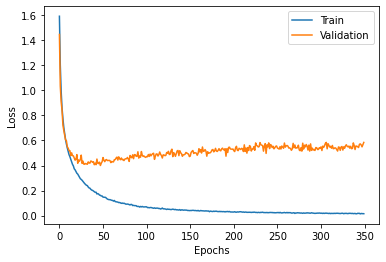

In [23]:
graph1 = sns.lineplot(x=range(0, 350), y=history["train"]["loss"])
graph2 = sns.lineplot(x=range(0, 350), y=history["val"]["loss"])
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Train", "Validation"])
plt.show()

## Plotting Train Accuracy vs Validation Accuracy

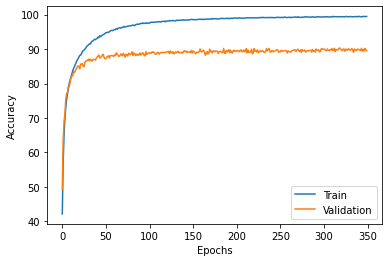

In [24]:
graph1 = sns.lineplot(x=range(0, 350), y=history["train"]["accuracy"])
graph2 = sns.lineplot(x=range(0, 350), y=history["val"]["accuracy"])
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Train", "Validation"])
plt.show()

In [25]:
pred_labels = torch.argmax(probs, 1)

## Plotting the Confusion Matrix

In [26]:
def plot_confusion_matrix(labels, pred_labels, classes):
    
    fig = plt.figure(figsize = (10, 10));
    ax = fig.add_subplot(1, 1, 1);
    cm = confusion_matrix(labels, pred_labels);
    cm = ConfusionMatrixDisplay(cm, display_labels = classes);
    cm.plot(values_format = 'd', cmap = 'Blues', ax = ax)
    plt.xticks(rotation = 20)

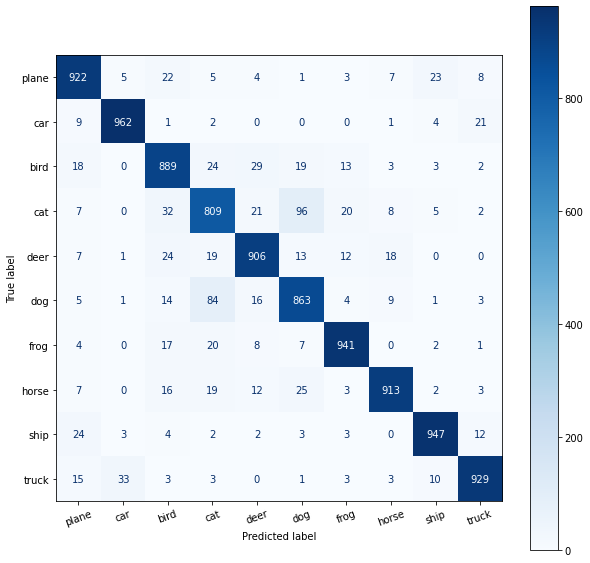

In [27]:
# plot_confusion_matrix(labels, pred_labels, classes)
plot_confusion_matrix(labels.to('cpu').data.numpy(), pred_labels.to('cpu').data.numpy(), classes) 